# Analise sobre consumo de drogas ilicítas em escolares do 9º ano do ensino fundamental no ano de 2015 - pesquisa PENSE 2015 - IBGE

## Objetivo do projeto

O Projeto abaixo visa estudar o perfil de consumo de drogas ilícitas no Brasil em uma amostra de escolares do 9º ano do ensino fundamental, levantada pelo IBGE em sua pesquisa PENSE 2015.

Também pretende-se propor uma modelagem inicial de modelagem preditiva, cuja aprimoramento pode ser sugestão de projetos futuros.

## Descrição do problema

A base de dados PENSE 2015 (Pesquisa Nacional de Saúde Escolar) foi organizada pelo IBGE (Instituto Brasileiro de Geografia e Estatística) com base em questionários preenchidos por mais de 100 mil estudantes brasileiros de todo o país, com suas percepções sobre saúde, violência, ambiente familiar, nutrição, comportamento de risco, prática de atividade física, entre outros.

As bases de dados podem ser obtidas acessando-se o link abaixo:

ftp://ftp.ibge.gov.br:21/pense/2015/microdados/

A base utilizada neste estudo foi a AMOSTRA1, presente no arquivo PENSE_2015_AMOSTRA1.zip; nesta, encontram-se os dados referentes aos escolares do 9º ano do ensino fundamental.

O objeto de estudo foi o perfil de consumo de drogas ilícitas identificado no questionário; tal perfil foi estratificado por UF, de modo a permitir uma avaliação de políticas públicas em nível estadual. 

Além disso, adotou-se uma abordagem de metodologia preditiva focada em machine learning para identificar quais as principais variáveis do próprio questionário que influenciam o consumo de drogas ilícitas, qual a correlação de cada uma com o perfil de consumo de entorpecentes e umas com as outras e como utilizá-las para predizer o comportamento estudado.

Neste repositório no GitHub estão também os seguintes arquivos:

- PENSE_AMOSTRA1_ALUNO_ESCOLA.CSV:  dataset principal com os dados da pesquisa.
- Dicionario_PENSE_Microdados_Amostra1.ods:  Dicionário com as legendas dos códigos de cada questão da pesquisa, com suas respostas possíveis.
- index.html:  índice com os links para acesso às bases da pesquisa em um site do IBGE.
- grupo.csv:  um resumo da legenda das questões da pesquisa.
- uf.csv:  lista relacionando os códigos de UFCENSO utilizada na pesquisa com as respectivas UF do Brasil

## Análise Exploratória e limpeza dos dados

Primeiro carregamos os módulos Python que utilizaremos no projeto:

In [1]:
# Importamos os modulos que serao utilizados

# Dataframes e arrays
import pandas as pd
import numpy as np

# Visualizacao de dados
import matplotlib.pyplot as plt
%matplotlib inline

# Eliminacao Recursiva de Atributos (RFE)
from sklearn.feature_selection import RFE

# cross validation e machine learning
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Warnings
import warnings
warnings.filterwarnings('ignore') # ignoramos os warnings 

Agora, importamos os datasets. Além do arquivo csv com os dados da pesquisa, vamos importar um resumo das questões (grupo.csv) e uma lista com as UF brasileiras por código 'UFCENSO', usado no questionário (uf.csv)

In [2]:
# Importamos os datasets que serao analisados
# Para este projeto, utilizaremos o arquivo contendo os dados de alunos e escolas
df_aluno_escola = pd.read_csv("arquivos_csv/PENSE_AMOSTRA1_ALUNOESCOLA.CSV", sep=';')
grupos = pd.read_csv("grupo.csv", sep = ';')
uf = pd.read_csv("uf.csv", sep = ';')

In [3]:
# Incluimos um campo UF no dataset

# organizamos os indices para o join
df_aluno_escola = df_aluno_escola.set_index('UFCENSO')
uf = uf.set_index('UFCENSO')

# operacao de join
df_aluno_escola = df_aluno_escola.join(uf, on='UFCENSO',how='inner')

# resetamos os indices
df_aluno_escola = df_aluno_escola.reset_index()
uf = uf.reset_index()

Agora, podemos fazer uma análise preliminar de nosso dataset:

- Participaram da pesquisa 102.072 alunos;
- Temos na base 295 colunas, sendo:

    - 9 campos com dados cadastrais (UFCENSO,ANOPESQ,PAIS,REGEOGR,MUNICIPIO_CAP,TIPO_MUNIC,aluno,escola,turma)
    - 2 campos referentes às UF, incluídos;
    - 284 campos referentes às questões da pesquisa e suas respectivas respostas

Lembrando que os conceitos de cada campo podem ser obtidos no arquivo 'Dicionario_PENSE_Microdados_Amostra1.ods', incluso no repositório e a descrição do código de cada questão também está no arquivo 'grupo.csv'.

In [4]:
# O dataset tem registros de 102.072 alunos, com 293 colunas,
# sendo 9 campos contendo dados cadastrais e 284 campos representando
# as perguntas do questionario
print(df_aluno_escola.shape)
df_aluno_escola.ftypes

(102072, 295)


UFCENSO           int64:dense
ANOPESQ           int64:dense
PAIS              int64:dense
REGEOGR           int64:dense
MUNICIPIO_CAP     int64:dense
TIPO_MUNIC        int64:dense
VB00004           int64:dense
VB01001           int64:dense
VB01002           int64:dense
VB01003           int64:dense
VB01004           int64:dense
VB01005           int64:dense
VB01006           int64:dense
VB01007           int64:dense
VB01008A          int64:dense
VB01010A          int64:dense
VB01011           int64:dense
VB01012           int64:dense
VB01013           int64:dense
VB01014           int64:dense
VB01015A          int64:dense
VB01016           int64:dense
VB01017           int64:dense
VB01018           int64:dense
VB01019           int64:dense
VB01020A          int64:dense
VB01021           int64:dense
VB01022           int64:dense
VB01023           int64:dense
VB01024           int64:dense
                     ...     
VE01P53           int64:dense
VE01P54           int64:dense
VE01P55   

Os pŕoximos passos consistem em fazer um tratamento de organização da base:
Substituir valores vazios (NaN) por 0 (zero) e converter tipos string em float

In [5]:
# Verificamos se há alguma coluna com celulas NaN
colunas_nao_vazias = df_aluno_escola.dropna(axis=1).columns
colunas_vazias =[]

for i in df_aluno_escola.columns:
    if i in colunas_nao_vazias:
        continue
    else:
        colunas_vazias.append(i)

colunas_vazias

['TEMPODESLOC', 'TEMPOTOTAL', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOEST']

In [6]:
# Substituimos os valores NaN por 0 (zero) nas colunas identificadas
df_aluno_escola[colunas_vazias] = df_aluno_escola[colunas_vazias].fillna(0)

In [7]:
# A colunas PESO veio em formato string, sendo que deveria ser float.
# Substituimos a virgula (,) por ponto (.) nos valores do campo e fazemos a conversao
df_aluno_escola['PESO'] = [x.replace(',','.') for x in df_aluno_escola['PESO']]
df_aluno_escola['PESO'] = pd.to_numeric(df_aluno_escola['PESO'])

Temos então o dataset pronto para a etapa de pré processamento

In [8]:
df_aluno_escola.head()

,UFCENSO,ANOPESQ,PAIS,REGEOGR,MUNICIPIO_CAP,TIPO_MUNIC,VB00004,VB01001,VB01002,VB01003,...,VE01P69,VE01P70,VE01P71,VE01P72,V0041,aluno,escola,turma,UNIDADE,UF
0,11,2015,76,1,1100205,1,1,2,1,14,...,1,1,1,1,1,1,1,1787,Rondônia,RO
1,11,2015,76,1,1100205,1,1,1,4,16,...,1,1,1,1,1,2,1,1787,Rondônia,RO
2,11,2015,76,1,1100205,1,1,1,1,13,...,1,1,1,1,1,3,1,1787,Rondônia,RO
3,11,2015,76,1,1100205,1,1,1,4,14,...,1,1,1,1,1,4,1,1787,Rondônia,RO
4,11,2015,76,1,1100205,1,1,1,1,14,...,1,1,1,1,1,5,1,1787,Rondônia,RO


## Pré Processamento

Nesta etapa, iremos atuar no dataset para extrair os insights que precisamos e também para prepará-lo para a etapa de machine learning

### Definição da varíável preditora

A primeira coisa a se fazer é identificar nossa variável preditora; pretendemos estudar o perfil de consumo de drogas ilícitas, mas não havia uma questão explícita no questionário sobre se o aluno era ou não usuário destas substâncias. Assim, foi necessário deduzir este campo de forma indireta.

No questionário, havia 3 (três) perguntas que tratavam sobre uso de drogas ilícitas mais diretamente:


- VB06003A: NOS ÚLTIMOS 30 DIAS, quantos dias você usou droga como maconha, cocaína, crack, cola, loló, lança-perfume, ecstasy, oxy, etc?

- VB06004A: NOS ÚLTIMOS 30 DIAS, quantos dias você usou maconha? 

- VB06005A: NOS ÚLTIMOS 30 DIAS, quantos dias você usou crack?


Estas questões tinham todas o mesmo padrão de respostas, a seguir:


- -1: Pulo no questionario
- 1: Nenhum dia nos ultimos 30 dias (0 dia)
- 2: 1 ou 2 dias nos ultimos 30 dias
- 3: 3 a 9 dias nos ultimos 30 dias
- 4: 10 ou mais dias nos ultimos 30 dias
- 99: Não informado


Com base nas questões e no padrão de respostas, definiram-se 3 (três) classes de usuários para os alunos:

- usuário: respondeu os itens 2 a 4 em pelo menos 1 (uma) das questões;
- não usuário: respondeu o item 1 em todas as questões;
- nâo respondeu: respondeu os itens -1 ou 99 em todas as questões

Assim, foi possível definir níveis para a variável preditora, que aqui chamamos de 'tipo_usuario', que informa se o aluno é ou não consumidor de drogas ilícitas, segundo este critério.

In [9]:
# Definindo os alunos que serão considerados como usuários de drogas
# Há 3 niveis: usuarios (1), nao_usuarios (2) e nao_responderam (3)

# Criacao da funcao
def usuario_droga(x):
    # nao_respondidos
    if (x['VB06003A'] == -1 or x['VB06003A'] == 99) \
    and (x['VB06004A'] == -1 or x['VB06004A'] == 99) \
    and (x['VB06005A'] == -1 or x['VB06005A'] == 99):
        return 3
    # nao_usuarios
    elif x['VB06003A'] == 1 \
    and x['VB06004A'] == 1 \
    and x['VB06005A'] == 1:
        return 2
    # usuarios
    else:
        return 1

In [10]:
# Agora, atualizamos o dataframe com uma coluna com a identificacao 
df_aluno_escola['tipo_usuario'] = df_aluno_escola.apply(usuario_droga, axis=1)

### Estratificação do perfil de consumo de drogas ilícitas por UF

Aplicando o conceito de definição de usuário drogas ilícitas na base, conseguimos visualizar o perfil de consumo; também estratificamos este perfil por UF, de modo a dar um viés de análise para políticas púlicas em nível estadual.

No Brasil, sobre o total de 102.072 alunos, a distribuição do perfil destes usuários ficou da seguinte forma:

- usuários: 4.473 alunos
- não usuários: 4.152 alunos
- não responderam: 93.447 alunos

Com estes dados, calculamos mais 2 (dois) indicadores:

- indice_usuario: percentual de usuarios de drogas em relação aos que responderam o questionário
- indice_resposta: percentual de alunos que responderam em relação ao total da amostra

Analisando as informações, podemos tirar as seguintes conclusões:

Houve um número muito grande de alunos que não informaram seu perfil (apenas 8,5% o fizeram). Isto sugere constrangimento com as perguntas e acaba comprometendo a quantidade de dados para se fazer o estudo. Formas mais indiretas de se obter os dados ou mais sutis de elaborar o questionário poderiam ser aplicadas para evitar esta perda de informações;

Dos 8,5% que informaram o perfil, 51,8% foram considerados como usuários de drogas ilícitas. Não temos como inferir a proporção de toda a amostra, devido ao baixo índice de resposta, mas o número é preocupante, principalmente por se tratar de jovens e que frequentam a escola.

Ao se observar a estratificação por UF, o comportamento dos números é relativamente homogêneo; o menor índice de usuários é do RN, de 42,1%, com índice de resposta de 4,5%; já o maior índice de usuários é de RR, de 58,5%, com índice de resposta de 11,3%


In [11]:
# Uma vez definido quem os tipos de usuarios, podemos calcular:
# indice_usuario: percentual de usuarios de drogas em relacao aos que responderam o questionario
# indice_resposta: percentual de alunos que responderam em relacao ao total da amostra

# Dataframe totalizando os niveis
df_tot = df_aluno_escola[['aluno', 'tipo_usuario']].groupby('tipo_usuario').count()

# Pivot table agrupada por UF
df_usr = df_aluno_escola.pivot_table(index=['UF'], columns='tipo_usuario',
                                     values='aluno', aggfunc='count')
df_usr['indice_usuario'] = df_usr[1] / (df_usr[1] + df_usr[2])*100
df_usr['indice_resposta'] = (1 - df_usr[3] / (df_usr[1] + df_usr[2] + df_usr[3]))*100

# Sumarizacao dos resultados
print("total_amostra: %.d \t\t total_sem_resposta: %.d \n\n\
total com resposta: %.d \t usuarios: %.d \n \t\t\t\t nao_usuarios: %.d\n\n\
indice_usuario: %.2f%% \t indice_resposta: %.2f%%"%
      (df_tot.iloc[0, 0]+df_tot.iloc[1, 0]+df_tot.iloc[2, 0],
       df_tot.iloc[2, 0],
       df_tot.iloc[0, 0]+df_tot.iloc[1, 0],
       df_tot.iloc[0, 0],df_tot.iloc[1, 0],
       df_tot.iloc[0, 0]/(df_tot.iloc[0, 0]+df_tot.iloc[1, 0])*100,
       (1-(df_tot.iloc[2, 0]/(df_tot.iloc[0, 0]+df_tot.iloc[1, 0]+df_tot.iloc[2, 0])))*100))

print("\n\nAbertura por UF:")
df_usr.sort_values('indice_usuario', ascending=False)

total_amostra: 102072 		 total_sem_resposta: 93447 

total com resposta: 8625 	 usuarios: 4473 
 				 nao_usuarios: 4152

indice_usuario: 51.86% 	 indice_resposta: 8.45%


Abertura por UF:


tipo_usuario,1,2,3,indice_usuario,indice_resposta
UF,,,,,
RR,206,146,2760,58.522727,11.311054
SP,243,178,3256,57.719715,11.449551
GO,306,228,4825,57.303371,9.964546
TO,108,86,2951,55.670103,6.168521
RJ,199,159,3893,55.586592,8.421548
CE,139,114,3408,54.940711,6.910680
RS,187,156,2040,54.518950,14.393621
AP,135,113,3766,54.435484,6.178376
PE,158,136,4243,53.741497,6.480053


### Pré Processamento e Data Cleaning

Nesta etapa, iremos preparar os dados para o desenvolvimento do modelo de machine learning; também iremos estudar as correlações entre as variáveis a fim de se fazer uma seleção de atributos.

Há 3 ações que precisam ser implementadas:

1) Uma vez que temos 93.447 alunos que não responderam adequadamente as questões sobre o uso de entorpecentes, precisamos eliminar estes registros da base;

2) Como temos 296 atributos, temos que reduzir a dimensionalidade da base, de modo a tornar a aplicação da modelagem preditiva mais efetiva. Neste projeto, aplicaremos a Eliminação Recursiva de Atributos (RFE) para tentar reduzir a base para 30 variáveis;

3) Iremos avaliar o perfil de correlações entre as variáveis, para extrair insights sobre a modelagem preditiva.

In [12]:
# Eliminando os registros de alunos que nao responderam sobre uso de drogas
df_aluno_escola2 = df_aluno_escola[df_aluno_escola['tipo_usuario'] != 3]
print(df_aluno_escola2.shape)

(8625, 296)


In [13]:
# Aplicacao da RFE
campos_a_excluir = ['aluno','VB06003A','VB06004A','VB06005A','UNIDADE','UF',
                   'ANOPESQ','PAIS','PESO','escola','turma']
campos_a_utilizar = df_aluno_escola2.columns.drop(campos_a_excluir)
df_aluno_escola3 = df_aluno_escola2[campos_a_utilizar]

X_res = df_aluno_escola3.iloc[:, :284]
Y_res = df_aluno_escola3.iloc[:, 284]

# RFE fit
rfe_fit = RFE(estimator=LogisticRegression(), n_features_to_select=30).fit(X_res, Y_res)

In [14]:
# Utilizacao da RFE para extrair os campos que serão avaliados para modelagem 
dfcheck = pd.DataFrame(rfe_fit.ranking_, columns=['rank'])
dfcheck.reset_index()
dfcheck['feature'] = df_aluno_escola3.iloc[:, :284].columns
col = dfcheck[dfcheck['rank'] == 1]['feature']

df_aluno_escola4 = df_aluno_escola3[col]
df_aluno_escola4['tipo_usuario'] = df_aluno_escola2['tipo_usuario']

print(df_aluno_escola4.shape)
df_aluno_escola4.dtypes

(8625, 31)


MUNICIPIO_CAP      int64
TEMPODESLOC      float64
TEMPOTOTAL       float64
TEMPOEDFIS       float64
TEMPOEXTRA       float64
TEMPOEST         float64
VB04002            int64
VB04003            int64
VB04008A           int64
VB04009            int64
VB04010            int64
VB04011            int64
VB05004            int64
VB05005            int64
VB05006A           int64
VB06002            int64
VB08002            int64
VB09002            int64
VB09003            int64
VB09007A           int64
VB09008            int64
VB09009            int64
VB09010            int64
VB09011            int64
VB09012            int64
VB09013A           int64
VB11006            int64
VB13006            int64
ESTRATO_EXP        int64
ESTRATOGEOREG      int64
tipo_usuario       int64
dtype: object

Neste ponto, faremos uma avaliação qualitativa dos campos extraídos e uma análise da matriz de correlações entre as variáveis.

Das variáveis, podemos verificar alguns padrões na extração: os atributos que o modelo sugeriu como mais representativos para a definição do perfil de consumo de drogas são relativos a:

- Localização geográfica (município, códigos de região), oq ue aponta para o efeito de políticas municipais diversas;
- Tempo de prática de atividade física;
- Hábitos de consumo de drogas lícitas, como tabagismo e alcool;
- Idade em que usou uma droga ilícita pela primeira vez;
- Hábitos de segurança;
- Histórico de abuso sexual;
- Histórico de violência;
- Auto estima;
- Hábitos referentes à saúde;
- Hábitos referentes à segurança

Quanto à matriz de correlação, vemos alguns padrões de correlações altas entre algumas das variáveis, mas, no geral, os coeficientes de correlação são baixos; provavelmente, algoritmos não lineares terão mais eficácia neste caso.

MUNICIPIO_CAP : Município 

TEMPODESLOC : Refere-se ao tempo médio diário acumulado pelo escolar, com o deslocamento da casa para escola e da escola para casa feito a pé ou de bicicleta, nos últimos sete dias anteriores à pesquisa. Em minutos. 

TEMPOEDFIS : Refere-se ao tempo médio acumulado, nos últimos sete dias anteriores à pesquisa, que o escolar fez atividade física ou esporte durante as aulas de educação física na escola. Em minutos. 

TEMPOEXTRA : Refere-se ao tempo médio diário acumulado pelo escolar com a prática de alguma atividade física extraescolar como esportes, dança, ginástica, musculação, lutas ou outra atividade, nos últimos sete dias anteriores à data da pesquisa. Em minutos 

TEMPOTOTAL : A atividade física acumulada foi estimada calculando o produto entre o número de dias e o tempo médio que os escolares gastam em atividades físicas, nos sete dias anteriores à pesquisa, considerando os seguintes domínios: ir e voltar da escola, aulas de educação física e outras at

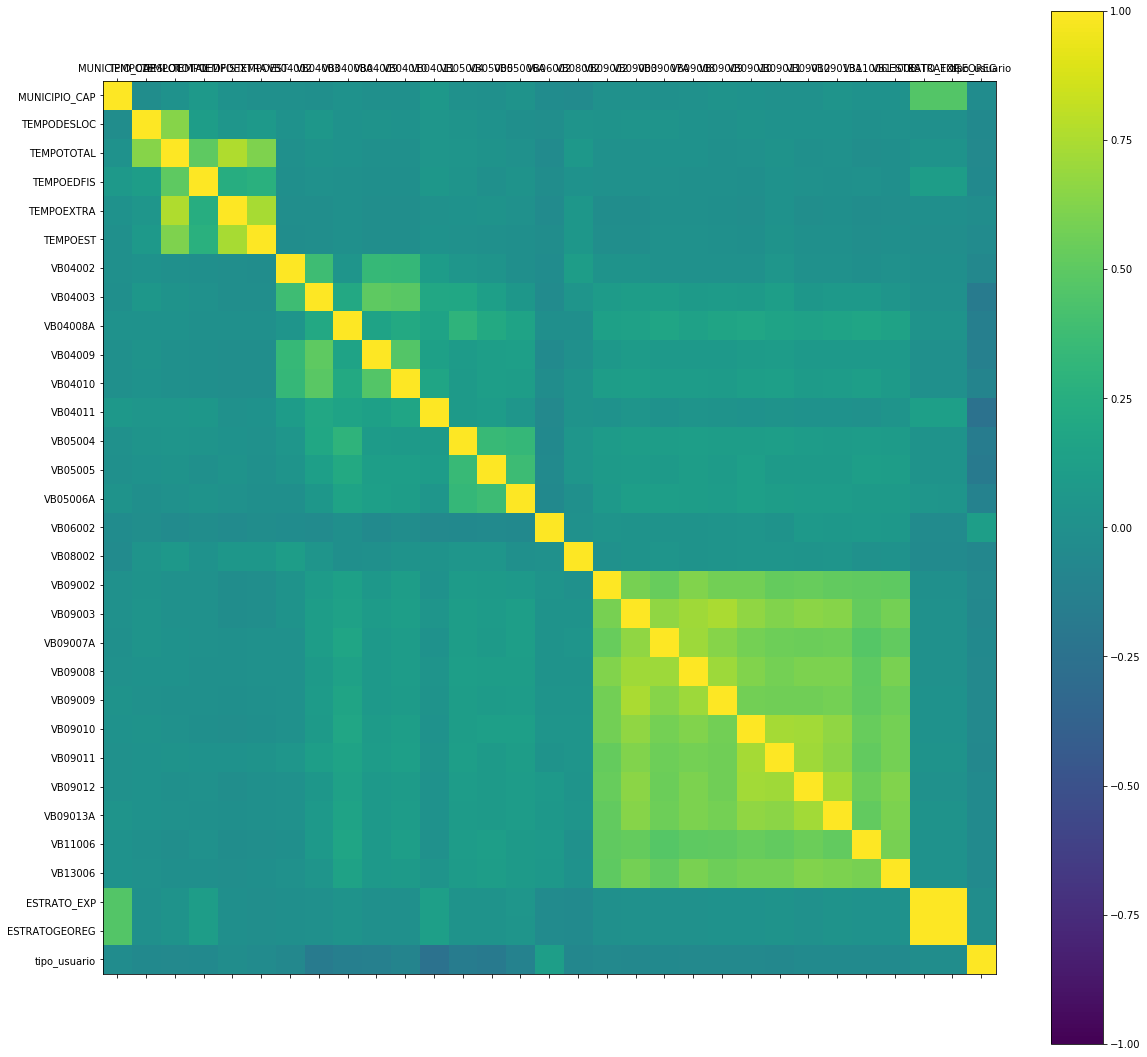

In [15]:
# Analise descritiva dos campos a serem avaliadas
dic = dict(grupos[['CAMPO','DESCRICAO']].values)

for k in list(dic.keys()):
    if k in list(col):
        print(k, ':', dic.get(k), '\n')
        
# Matriz de Correlação com nomes das variáveis
correlations = df_aluno_escola4.corr()
colunas = df_aluno_escola4.columns

# Plot da mariz de correlacoes
fig = plt.figure(figsize=(20,19))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 31, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(colunas)
ax.set_yticklabels(colunas)
plt.show()

# Machine Learning

## Teste dos modelos de machine learning
Uma vez extraídos os arrays, testaremos 9 (nove) modelos de classificação binária pelo critério de acurácia.

Utilizaremos o método Cross Validation, que extrairá 10 grupos de dados de treino e de teste, aplicará o modelo de machine learning e então extrai a média e o desvio-padrão das acuracidades.

In [16]:
# Preparando os dados para a etapa de machine learning
X = df_aluno_escola4.iloc[:, :30]
Y = df_aluno_escola4.iloc[:, 30]

LR: 51.18% (2.34%)
LDA: 70.38% (2.02%)
KNN: 51.51% (1.39%)
NB: 50.23% (2.41%)
DTC: 64.13% (2.56%)
SVC: 51.87% (2.39%)
XGB: 73.44% (2.35%)
RDF: 70.84% (2.07%)
KME: 13.09% (14.91%)


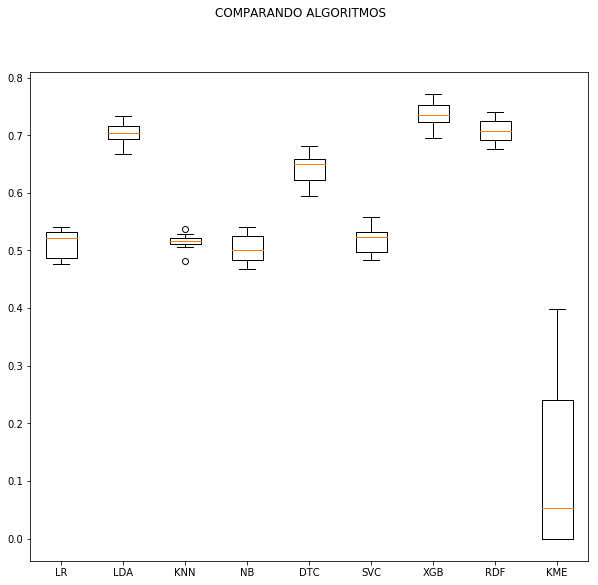

In [17]:
# Carrega uma lista com os modelos de machine learning que serão testados
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('NB', GaussianNB()))
modelos.append(('DTC', DecisionTreeClassifier()))
modelos.append(('SVC', SVC()))
modelos.append(('XGB', GradientBoostingClassifier()))
modelos.append(('RDF', RandomForestClassifier()))
modelos.append(('KME', KMeans()))

# Aplica o cross validation para cada modelo e extrai-lhes os parâmetros para teste 
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    cross_val_result = model_selection.cross_val_score(modelo, X, Y, cv=kfold, scoring='accuracy')
    
    resultados.append(cross_val_result)
    nomes.append(nome)
    
    text = '%s: %.2f%% (%.2f%%)' % (nome, cross_val_result.mean()*100, cross_val_result.std()*100)
    print(text)

# Plota um grafico boxplot com o perfil das acuracidades de cada modelo
fig = plt.figure(figsize=(10,9))
fig.suptitle('COMPARANDO ALGORITMOS')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

Podemos observar que o algoritmo XGBoost teve o melhor desempenho: acuracidade média de 73,5% com desvio-padrão de 2,3%

## Aplicação do algoritmo selecionado e estratificação das acuracidades por UF

Finalmente, aplica-se o modelo selecionado ao conjunto de dados dos alunos identificados como usuários ou não usuários.

O XGBoost teve uma acuracidade de 76,7%, sendo que acertou em 75,6% para os usuários e 77,8% para os não usuários.

Na estratificação entre as UFs, os acertos variaram de 69,8% (SP) a 82,7% (PA). 

In [18]:
# Criação e fit do modelo
modelo = GradientBoostingClassifier(random_state=0)
model_fit = modelo.fit(X, Y)

In [19]:
# Criação do vetor de previsões
Y_pred = model_fit.predict(X)

In [20]:
# Inclusão dos vetores de previsão, dos dados de identificação e do cálculo de acertos no dataset
df_aluno_escola4['tipo_usuario_pred'] = Y_pred
df_aluno_escola4['aluno'] = df_aluno_escola2['aluno']
df_aluno_escola4['UF'] = df_aluno_escola2['UF']
df_aluno_escola4['acerto'] = \
df_aluno_escola4.apply(lambda x: 1 if x.tipo_usuario==x.tipo_usuario_pred else 0, axis=1)

In [21]:
# Relatorio de Classificacao
print("\t\t ACURACIA: %.2f%%"%(accuracy_score(y_true=Y, y_pred=Y_pred)*100),'\n\n')

print(classification_report(y_pred=Y_pred, y_true=Y), '\n')

df_piv = pd.pivot_table(df_aluno_escola4, index ='tipo_usuario', columns='tipo_usuario_pred',
                       values='aluno',aggfunc='count')

print("indice_acerto_usuarios: %.2f%% \nindice_acertos_nao_usuarios: %.2f%%"%
     (df_piv[1][1]/(df_piv[1][1]+df_piv[2][1])*100,
     df_piv[2][2]/(df_piv[1][2]+df_piv[2][2])*100))

df_piv

		 ACURACIA: 76.66% 


              precision    recall  f1-score   support

           1       0.79      0.76      0.77      4473
           2       0.75      0.78      0.76      4152

   micro avg       0.77      0.77      0.77      8625
   macro avg       0.77      0.77      0.77      8625
weighted avg       0.77      0.77      0.77      8625
 

indice_acerto_usuarios: 75.63% 
indice_acertos_nao_usuarios: 77.77%


tipo_usuario_pred,1,2
tipo_usuario,,
1,3383,1090
2,923,3229


In [22]:
# Pivot table agrupada por UF
df_usr = df_aluno_escola4.pivot_table(index='UF', columns='acerto',
                                     values='aluno', aggfunc= 'count')
df_usr['indice_acerto'] = df_usr[1] / (df_usr[1] + df_usr[0])*100

print("\n\nAbertura por UF:")
df_usr.sort_values('indice_acerto', ascending=False)



Abertura por UF:


acerto,0,1,indice_acerto
UF,,,
PA,34,163,82.741117
RR,66,286,81.250000
AC,53,227,81.071429
PI,28,119,80.952381
RN,40,155,79.487179
SC,111,414,78.857143
BA,44,161,78.536585
TO,42,152,78.350515
CE,55,198,78.260870


# Conclusão

Conseguimos efetivar os objetivos; estudamos o perfil dos usuários e não-usuários de drogas por UF; selecionamos os 30 primeiros atributos dentro do universo da pesquisa que mais explicam o consumo de drogas; e propusemos uma abordagem de modelagem preditiva, com a estratificação dos acertos no nível de UF.

A circulação de drogas ilícitas é um problema tanto de segurança pública, quanto de saúde pública; criar políticas adequadas para o combate e prevenção a seu consumo é de suma importância. 

Este trabalho buscou ajudar no sentido de aproveitar uma pesquisa sobre um público jovem para mapear possíveis fatores que podem ser considerados na elaboração de tais políticas.